# <span style="font-family:Verdana;"> Real-time ASL Recognition using Webcam Feed </span>

****

<span style="font-family:Verdana;">📌 The aim of this notebook is to use your pre-trained TensorFlow Lite model to perform real-time American Sign Language (ASL) recognition from YOUR webcam video! The model was trained using distance and angle-based features extracted from the 3D landmarks detected in each frame as shown in this [notebook](https://www.kaggle.com/code/josephzahar/distance-angle-based-features-using-keras). 
</span>

<span style="font-family:Verdana;">The code loads the pre-trained model using the TensorFlow Lite Interpreter, and extracts the signature runner and input/output signatures. The script will capture the frames from the webcam in real-time, and uses the Mediapipe Holistic library to detect 3D landmarks on the hand. The extracted landmarks are added to a sequence data list, which is then used to make a prediction for every 15 frames. </span>

<span style="font-family:Verdana;">
    
**With this notebook we present:**
    
* The use of a pre-trained model allows for quick and accurate recognition of ASL signs, without the need for time-consuming training on large datasets.
* The distance and angle-based features used in the model are effective in capturing the unique characteristics of each sign, making it robust to variations in lighting, hand placement, and background.
* The real-time nature of the script allows for immediate feedback to the user, making it useful for testing and refining algorithms for ASL recognition. </span>

## <span style="font-family:Verdana;"> Algorithm Diagram </span>

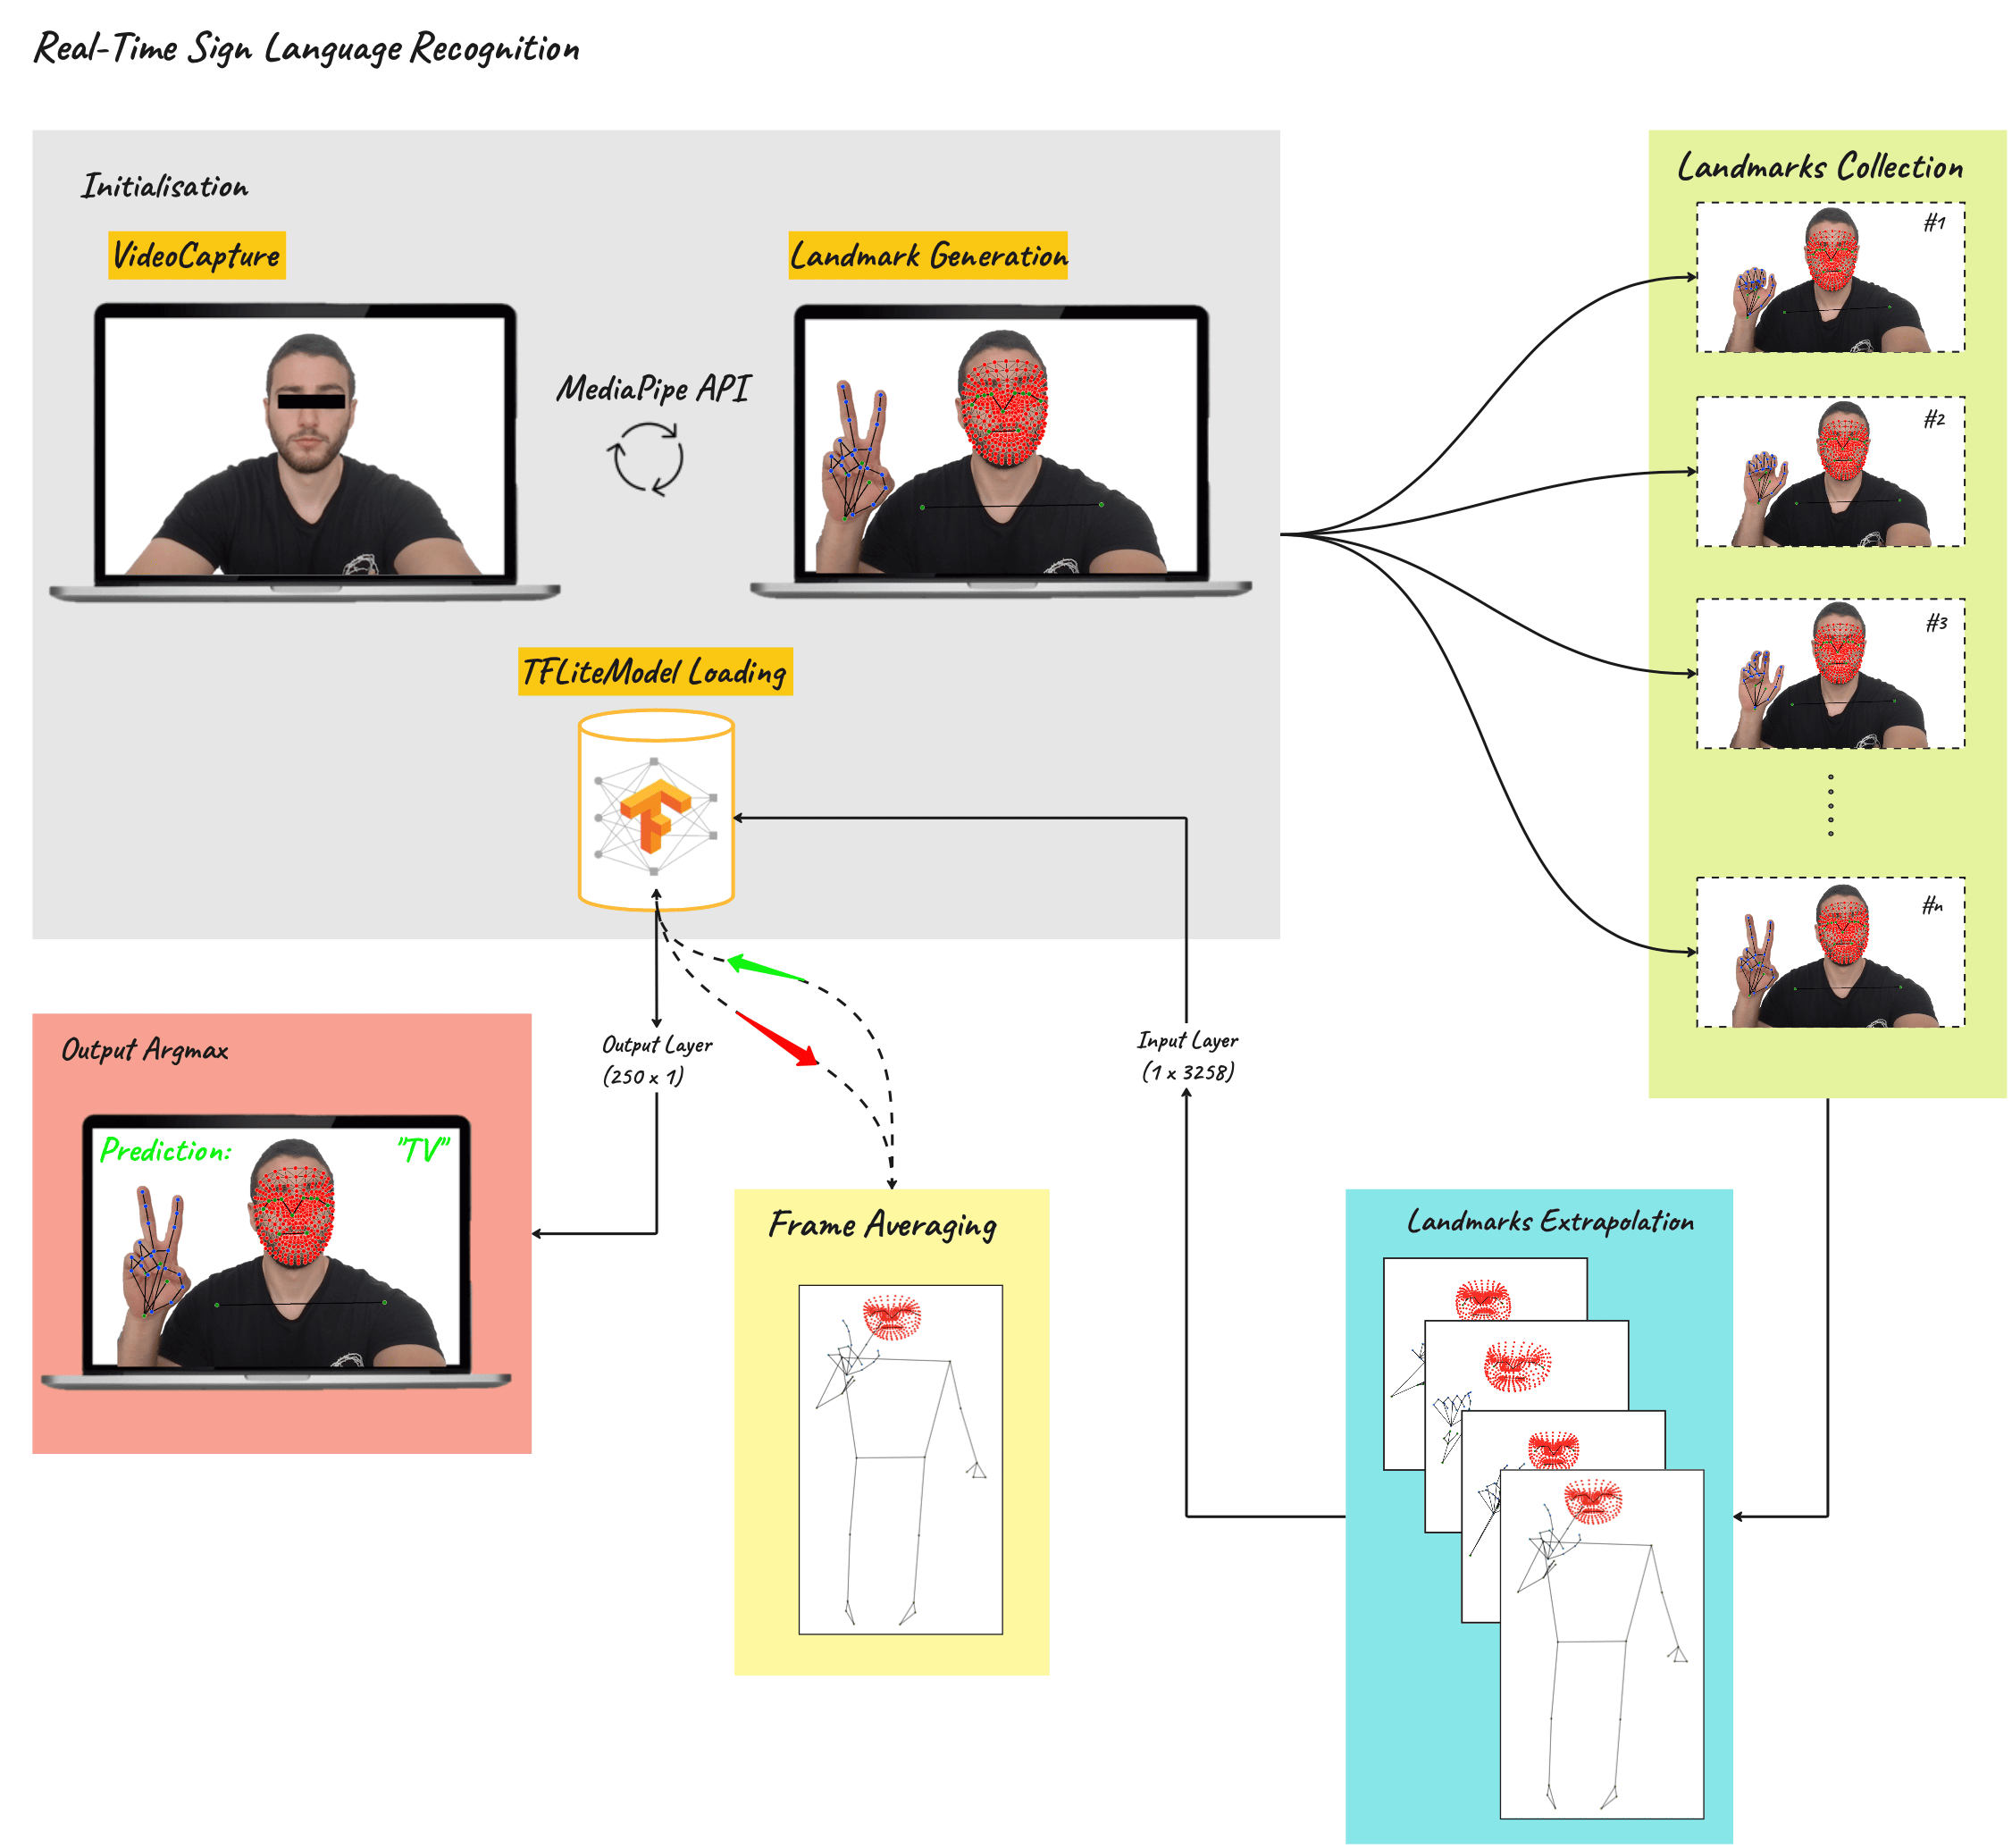
***

### <span style="font-family:Verdana;"> Import Packages </span>

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import json
import pandas as pd

import mediapipe as mp
# import tflite_runtime.interpreter as tflite
    
import tensorflow as tf

## <span style="font-family:Verdana;"> Methodology </span>

### <span style="font-family:Verdana;"> MediaPipe Model API </span>

In [2]:
mp_holistic = mp.solutions.holistic # holistic model
mp_drawing = mp.solutions.drawing_utils # drawing utilities
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # color conversion
    image.flags.writeable = False # img no longer writeable
    pred = model.process(image) # make landmark prediction
    image.flags.writeable = True  # img now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # color reconversion
    return image, pred

### <span style="font-family:Verdana;"> Landmarks Formatting Function </span>

In [3]:
def draw(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=3, circle_radius=3),
                              mp_drawing.DrawingSpec(color=(0,0,0), thickness=1, circle_radius=0))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,150,0), thickness=3, circle_radius=3),
                              mp_drawing.DrawingSpec(color=(0,0,0), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(200,56,12), thickness=3, circle_radius=3),
                              mp_drawing.DrawingSpec(color=(0,0,0), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(250,56,12), thickness=3, circle_radius=3),
                              mp_drawing.DrawingSpec(color=(0,0,0), thickness=2, circle_radius=2))

### <span style="font-family:Verdana;"> Landmarks Extraction </span>

In [4]:
def extract_coordinates(results):
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]) if results.face_landmarks.landmark else np.zeros(468, 3)
    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]) if results.pose_landmarks.landmark else np.zeros(33, 3)
    try:
        lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark])
    except AttributeError:
        lh = np.zeros((21, 3))
        
    # lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks.landmark is not None else 
    try:
        rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark])
    except AttributeError:
        rh = np.zeros((21, 3))
    # rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks.landmark is not None else np.zeros(21, 3)
    return np.concatenate([face, lh, pose, rh])


### <span style="font-family:Verdana;"> Helper Functions </span>

In [5]:
def load_json_file(json_path):
    with open(json_path, 'r') as f:
        sign_map = json.load(f)
    return sign_map

class CFG:
    data_dir = "./"
    sequence_length = 12
    rows_per_frame = 543

ROWS_PER_FRAME = 543
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)
    
sign_map = load_json_file(CFG.data_dir + 'sign_to_prediction_index_map.json')
# train_data = pd.read_csv(CFG.data_dir + 'train.csv')

s2p_map = {k.lower():v for k,v in load_json_file(CFG.data_dir + "sign_to_prediction_index_map.json").items()}
p2s_map = {v:k for k,v in load_json_file(CFG.data_dir + "sign_to_prediction_index_map.json").items()}
encoder = lambda x: s2p_map.get(x.lower())
decoder = lambda x: p2s_map.get(x)

## <span style="font-family:Verdana;"> Putting Everything Together </span>

In [24]:
def real_time_asl(video_name):
    interpreter = tf.lite.Interpreter("./tflite_models/ensemble_model.tflite")
    found_signatures = list(interpreter.get_signature_list().keys())
    prediction_fn = interpreter.get_signature_runner("serving_default")

    sequence_data = []
    
    cap = cv2.VideoCapture(f'./static/videos/{video_name}.mp4')
    print(cap)
    if not cap.isOpened():
        print("not opened")
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                image, results = mediapipe_detection(frame, holistic)
                # print(results.__dict__)
                draw(image, results)
                # cv2.namedWindow('image', cv2.WINDOW_AUTOSIZE)
                # cv2.imshow('image', image)
                # cv2.waitKey()
                
                # print(results.face_landmarks)
                # print(results.pose_landmarks)
                # print(results.left_hand_landmarks)
                # print(results.right_hand_landmarks)

                landmarks = extract_coordinates(results)
                sequence_data.append(landmarks)
                
                    
                # print(len(sequence_data))
                # cv2.namedWindow('image', cv2.WINDOW_AUTOSIZE)
                
                # if cv2.waitKey(10) & 0xFF == ord("q"):
                #     break
            else:
                # if len(sequence_data) % 10 == 0:
                # print(sequence_data)
                prediction = prediction_fn(inputs=np.float32(np.array(sequence_data)))
                prediction = prediction["outputs"]
                prediction = prediction[0]
                #print(prediction.shape)
                sign = np.argmax(prediction)
               # print(f"Prediction:    {sign}")
                top5_sign = prediction.argsort()[-10:][::-1]
                #print(f"Top 5:    {top5_sign}")
                #print(f"probability:  {prediction[top5_sign]}")
                top5_sign_decoded = [decoder(s) for s in top5_sign]
                print(f"Prediction:    {decoder(sign)}")
                print(f"Top 5:    {top5_sign_decoded}")
                # cv2.putText(image, f"Prediction:    {decoder(sign)}", (3, 30),
                #             cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                # cv2.imshow('Video',image)
                # cv2.waitKey()
                break
        print("end")
        cap.release()
        cv2.destroyAllWindows()
      
      
videos = ['bye', 'cut', 'for', 'see', 'wait', 'white']
for video in videos:
    print(video)
    real_time_asl(video)
# real_time_asl()

bye
< cv2.VideoCapture 000001F5E910C270>
Prediction:    shower
Top 5:    ['shower', 'child', 'lion', 'garbage', 'cloud', 'sun', 'hello', 'hat', 'alligator', 'car']
end
cut
< cv2.VideoCapture 000001F5E5B4B830>
Prediction:    hat
Top 5:    ['hat', 'giraffe', 'shower', 'lion', 'moon', 'cloud', 'arm', 'brother', 'all', 'zipper']
end
for
< cv2.VideoCapture 000001F5E941D3B0>
Prediction:    for
Top 5:    ['for', 'penny', 'brother', 'closet', 'look', 'face', 'because', 'moon', 'there', 'go']
end
see
< cv2.VideoCapture 000001F5E911AEF0>
Prediction:    see
Top 5:    ['see', 'look', 'gum', 'hen', 'person', 'cute', 'wet', 'dog', 'cut', 'will']
end
wait
< cv2.VideoCapture 000001F5E9128870>
Prediction:    hungry
Top 5:    ['hungry', 'wet', 'white', 'wait', 'thirsty', 'now', 'old', 'thankyou', 'like', 'cute']
end
white
< cv2.VideoCapture 000001F5E942A750>
Prediction:    white
Top 5:    ['white', 'hungry', 'police', 'like', 'look', 'zebra', 'shhh', 'jacket', 'water', 'animal']
end
